In [26]:
import os
import numpy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [27]:
channel_name = "MUC5AC"
channel_num = "21"
measurement = "mean"

In [28]:
sample_id_colors = sns.color_palette("hls", 8)

In [29]:
path = "/Volumes/sep22/home/wet_lab/_Experiments/007_COPD_CO_IMC/analysis/Imaris_analysis/epithelium"
save_fig = "/Volumes/sep22/home/wet_lab/_Experiments/007_COPD_CO_IMC/analysis/Imaris_analysis/figures"

In [30]:
# List all files in the folder
files_count = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Print the number of files
print(f"Number of files in the folder: {len(files_count)}")

Number of files in the folder: 30


In [31]:
# Empty list
file_list = []

# Dictionary to store DataFrames
dataframes_expression = {}
dataframes_cells = {}

In [32]:
# Loop through the files in the specified path
for file in os.listdir(path):
    file_list.append(file)

    # Construct full file path
    file_path = os.path.join(path, file)

    # Read CSV or Excel based on file type
    if file.endswith(".csv"):
        df = pd.read_csv(file_path)
    elif file.endswith((".xls", ".xlsx")):
        df = pd.read_excel(file_path)
    else:
        print(f"Skipping: {file} (Unsupported format)")
        continue  # Skip unsupported files

    # Set the first row as the header
    df.columns = df.iloc[0]
    df = df[1:]

    # Set the first column as the index
    df.set_index(df.columns[0], inplace=True)

    # Store DataFrame in dictionary using file name (without extension)
    df_name = os.path.splitext(file)[0]
    df_name = df_name.upper()  # make uppercase to match images name

    if df_name.endswith("_CELLS"):
        df_name = df_name.rsplit('_', 1)[0]
        dataframes_cells[df_name] = df
    elif df_name.endswith("_EXPRESSION"):
        df_name = df_name.rsplit('_', 1)[0]
        dataframes_expression[df_name] = df
    else:
        print(f"{df_name}: Neither cells nor expression information")
        
# Print DataFrame names and their counts
print("Loaded Cells DataFrames:", list(dataframes_cells.keys()))
print("Number of Cells DataFrames:", len(dataframes_cells))
print("Loaded Expression DataFrames:", list(dataframes_expression.keys()))
print("Number of Expression DataFrames:", len(dataframes_expression))
print("Done")


Loaded Cells DataFrames: ['D5_D6_D7_D8_002', 'D9_D10_001', 'D5_D6_D7_D8_003', 'D1_D2_D3_D4_001', 'D1_D2_D3_D4_002', 'D4_2_D2_2_D10_2_004', 'D4_2_D2_2_D10_2_002', 'D6_2_D7_2_001', 'D1_D2_D3_D4_004', 'D1_2_D8_2_001', 'D1_2_D8_2_002', 'D4_2_D2_2_D10_2_003', 'EPITHELIUM_ROI_EXAMPLE', 'D6_2_D7_2_002', 'D5_D6_D7_D8_001']
Number of Cells DataFrames: 15
Loaded Expression DataFrames: ['D1_D2_D3_D4_004', 'D1_D2_D3_D4_002', 'D9_D10_001', 'D1_2_D8_2_002', 'D4_2_D2_2_D10_2_003', 'D1_D2_D3_D4_001', 'D5_D6_D7_D8_003', 'D5_D6_D7_D8_002', 'D6_2_D7_2_002', 'EPITHELIUM_ROI_EXAMPLE', 'D4_2_D2_2_D10_2_002', 'D4_2_D2_2_D10_2_004', 'D6_2_D7_2_001', 'D5_D6_D7_D8_001', 'D1_2_D8_2_001']
Number of Expression DataFrames: 15
Done


In [33]:
# # import names
# images = pd.read_csv("/Users/sarapatti/Desktop/PhD_projects/Llyod_lab/COPD_CO_IMC/data/images.csv")
# images["imc_name"] = images["image"].apply(lambda x: os.path.splitext(x)[0])
# images.index = images["imc_name"] 
# images_dict = dict(zip(images.index, images["acquisition_description"]))

In [34]:
# import metadata
meta = pd.read_excel("/Users/sarapatti/Desktop/PhD_projects/Llyod_lab/COPD_CO_IMC/data/meta_data/meta.xlsx", index_col=0)

In [35]:
images_dict = dict(zip(meta.index, meta["slide_ID"]))
images_dict

{'D1_D2_D3_D4_004': 'D1',
 'D1_2_D8_2_002': 'D1_6',
 'D9_D10_001': 'D10',
 'D4_2_D2_2_D10_2_004': 'D10_6',
 'D1_D2_D3_D4_002': 'D2',
 'D4_2_D2_2_D10_2_003': 'D2_6',
 'D1_D2_D3_D4_001': 'D4',
 'D4_2_D2_2_D10_2_002': 'D4_6',
 'D5_D6_D7_D8_003': 'D6',
 'D6_2_D7_2_002': 'D6_6',
 'D5_D6_D7_D8_002': 'D7',
 'D6_2_D7_2_001': 'D7_6',
 'D5_D6_D7_D8_001': 'D8',
 'D1_2_D8_2_001': 'D8_6',
 'E10842_001': 'E10842',
 'D6_2_D7_2_003': 'laser_test',
 'D6_2_D7_2_004': 'laser_test',
 'D6_2_D7_2_005': 'laser_test',
 'D1_D2_D3_D4_005': 'laser_test'}

In [36]:
# Rename keys in dataframes_cells with values from images_dict
renamed_dataframes_cells = {}
for key, df in dataframes_cells.items():
    if key in images_dict:
        new_key = images_dict[key]
        renamed_dataframes_cells[new_key] = df
        print(key, ":", new_key)
    else:
        print(f"Key {key} not found in images_dict, keeping original key.")
        renamed_dataframes_cells[key] = df

# Replace the original dataframes_cells with the renamed one
dataframes_cells = renamed_dataframes_cells

D5_D6_D7_D8_002 : D7
D9_D10_001 : D10
D5_D6_D7_D8_003 : D6
D1_D2_D3_D4_001 : D4
D1_D2_D3_D4_002 : D2
D4_2_D2_2_D10_2_004 : D10_6
D4_2_D2_2_D10_2_002 : D4_6
D6_2_D7_2_001 : D7_6
D1_D2_D3_D4_004 : D1
D1_2_D8_2_001 : D8_6
D1_2_D8_2_002 : D1_6
D4_2_D2_2_D10_2_003 : D2_6
Key EPITHELIUM_ROI_EXAMPLE not found in images_dict, keeping original key.
D6_2_D7_2_002 : D6_6
D5_D6_D7_D8_001 : D8


In [37]:
# Rename keys in dataframes_cells with values from images_dict
renamed_dataframes_expression = {}
for key, df in dataframes_expression.items():
    if key in images_dict:
        new_key = images_dict[key]
        renamed_dataframes_expression[new_key] = df
        print(key, new_key)
    else:
        print(f"Key {key} not found in images_dict, keeping original key.")
        renamed_dataframes_expression[key] = df

# Replace the original dataframes_cells with the renamed one
dataframes_expression = renamed_dataframes_expression
dataframes_expression

D1_D2_D3_D4_004 D1
D1_D2_D3_D4_002 D2
D9_D10_001 D10
D1_2_D8_2_002 D1_6
D4_2_D2_2_D10_2_003 D2_6
D1_D2_D3_D4_001 D4
D5_D6_D7_D8_003 D6
D5_D6_D7_D8_002 D7
D6_2_D7_2_002 D6_6
Key EPITHELIUM_ROI_EXAMPLE not found in images_dict, keeping original key.
D4_2_D2_2_D10_2_002 D4_6
D4_2_D2_2_D10_2_004 D10_6
D6_2_D7_2_001 D7_6
D5_D6_D7_D8_001 D8
D1_2_D8_2_001 D8_6


{'D1': 0                                     Min           Max          Mean StdDev  \
 Variable                                                                       
 Area                         23315.240234  23315.240234  23315.240234      0   
 Circularity                         0.201         0.201         0.201      0   
 Distance from Origin          1258.598999   1258.598999   1258.598999      0   
 Distance to Image Border XY             0             0             0      0   
 Ellipse Axis A X                   -0.428        -0.428        -0.428      0   
 ...                                   ...           ...           ...    ...   
 Position X                    1012.452026   1012.452026   1012.452026      0   
 Position Y                     747.671021    747.671021    747.671021      0   
 Shortest Distance to Spots          0.188         0.188         0.188      0   
 Time                                    0             0             0      0   
 Time Index           

In [38]:
# Make dataframe of cell spot counts
data = {"Sample_ID": [], "Total Number of Spots": []}

for key in dataframes_cells:
    df = dataframes_cells[key]
    value = df.loc["Total Number of Spots", "Value"]
    data["Sample_ID"].append(key)
    data["Total Number of Spots"].append(value)

total_spots_df = pd.DataFrame(data)
total_spots_df.set_index("Sample_ID", inplace=True)

In [39]:
# Make dataframe of cell spot counts

data = {"Sample_ID": [], f" {measurement.capitalize()} {channel_name} expression": [], "Area (µm^2)": []}

if measurement == "median":
    for key in dataframes_expression:
        # Index on dataframe
        df = dataframes_expression[key]
        
        # Extract median area
        area = df.loc["Area", "Median"]
        
        # Extract median value of channel of interest
        result = df.loc["Intensity Median"]
        filtered_result = result[result["Channel"] == channel_num]
        if not filtered_result.empty:
            value = filtered_result["Median"].values[0]  # Extract the value from the Series
        else:
            value = None  # or some default value if no match is found
        
        # Add to dictionary
        data["Sample_ID"].append(key)
        data[f" Median {channel_name} expression"].append(value)
        data["Area (µm^2)"].append(area)

    # Calculate normalized expression
    data[f"Normalized {channel_name} expression (Area µm^2)"] = [v / a if a != 0 else None for v, a in zip(data[f" Median {channel_name} expression"], data["Area (µm^2)"])]
        
elif measurement == "mean":
    for key in dataframes_expression:
        # Index on dataframe
        df = dataframes_expression[key]
        
        # Extract mean area
        area = df.loc["Area", "Mean"]
        
        # Extract mean value of channel of interest
        result = df.loc["Intensity Mean"]
        filtered_result = result[result["Channel"] == channel_num]
        if not filtered_result.empty:
            value = filtered_result["Mean"].values[0]  # Extract the value from the Series
        else:
            value = None  # or some default value if no match is found
        
        # Add to dictionary
        data["Sample_ID"].append(key)
        data[f" Mean {channel_name} expression"].append(value)
        data["Area (µm^2)"].append(area)
    
    # Calculate normalized expression
    data[f"Normalized {channel_name} expression (Area µm^2)"] = [v / a if a != 0 else None for v, a in zip(data[f" Mean {channel_name} expression"], data["Area (µm^2)"])]

expression_COI = pd.DataFrame(data)
expression_COI.set_index("Sample_ID", inplace=True)

In [40]:
expression_COI

,Mean MUC5AC expression,Area (µm^2),Normalized MUC5AC expression (Area µm^2)
Sample_ID,,,
D1,19.973000,23315.240234,0.000857
D2,32.820000,42521.437500,0.000772
D10,20.624001,36388.929688,0.000567
D1_6,6.629000,56725.437500,0.000117
D2_6,113.476997,93118.421875,0.001219
D4,3.007000,44456.855469,0.000068
D6,30.417000,52062.960938,0.000584
D7,170.436996,11698.929688,0.014569
D6_6,97.153999,60523.562500,0.001605


In [41]:
# Merge dataframes based on the Sample_ID index
df_final = pd.merge(expression_COI, total_spots_df, left_index=True, right_index=True)
df_final

,Mean MUC5AC expression,Area (µm^2),Normalized MUC5AC expression (Area µm^2),Total Number of Spots
Sample_ID,,,,
D1,19.973000,23315.240234,0.000857,198
D2,32.820000,42521.437500,0.000772,1181
D10,20.624001,36388.929688,0.000567,259
D1_6,6.629000,56725.437500,0.000117,438
D2_6,113.476997,93118.421875,0.001219,720
D4,3.007000,44456.855469,0.000068,535
D6,30.417000,52062.960938,0.000584,790
D7,170.436996,11698.929688,0.014569,172
D6_6,97.153999,60523.562500,0.001605,427


In [42]:
df_final[f"Normalized {channel_name} expression (# of spots)"] = expression_COI[f" {measurement.capitalize()} {channel_name} expression"]/ df_final["Total Number of Spots"]
df_final

,Mean MUC5AC expression,Area (µm^2),Normalized MUC5AC expression (Area µm^2),Total Number of Spots,Normalized MUC5AC expression (# of spots)
Sample_ID,,,,,
D1,19.973000,23315.240234,0.000857,198,0.100874
D2,32.820000,42521.437500,0.000772,1181,0.027790
D10,20.624001,36388.929688,0.000567,259,0.079629
D1_6,6.629000,56725.437500,0.000117,438,0.015135
D2_6,113.476997,93118.421875,0.001219,720,0.157607
D4,3.007000,44456.855469,0.000068,535,0.005621
D6,30.417000,52062.960938,0.000584,790,0.038503
D7,170.436996,11698.929688,0.014569,172,0.990913
D6_6,97.153999,60523.562500,0.001605,427,0.227527


In [43]:
# Apply the natural logarithm to the specified column
df_final[f"Log Normalized {channel_name} expression (# of spots)"] = np.log(df_final[f"Normalized {channel_name} expression (# of spots)"])
df_final[f"Log Normalized {channel_name} expression (Area µm^2)"] = np.log(df_final[f"Normalized {channel_name} expression (Area µm^2)"])
df_final

,Mean MUC5AC expression,Area (µm^2),Normalized MUC5AC expression (Area µm^2),Total Number of Spots,Normalized MUC5AC expression (# of spots),Log Normalized MUC5AC expression (# of spots),Log Normalized MUC5AC expression (Area µm^2)
Sample_ID,,,,,,,
D1,19.973000,23315.240234,0.000857,198,0.100874,-2.293886,-7.062481
D2,32.820000,42521.437500,0.000772,1181,0.027790,-3.583079,-7.166726
D10,20.624001,36388.929688,0.000567,259,0.079629,-2.530373,-7.475564
D1_6,6.629000,56725.437500,0.000117,438,0.015135,-4.190765,-9.054524
D2_6,113.476997,93118.421875,0.001219,720,0.157607,-1.847651,-6.710027
D4,3.007000,44456.855469,0.000068,535,0.005621,-5.181324,-9.601332
D6,30.417000,52062.960938,0.000584,790,0.038503,-3.257031,-7.445207
D7,170.436996,11698.929688,0.014569,172,0.990913,-0.009129,-4.228887
D6_6,97.153999,60523.562500,0.001605,427,0.227527,-1.480487,-6.434491


In [44]:
df_final = pd.merge(df_final, meta, left_index=True, right_on="slide_ID")
df_final

,Mean MUC5AC expression,Area (µm^2),Normalized MUC5AC expression (Area µm^2),Total Number of Spots,Normalized MUC5AC expression (# of spots),Log Normalized MUC5AC expression (# of spots),Log Normalized MUC5AC expression (Area µm^2),slide_ID,acquisition_description,patient_ID,...,RV/TLC,Cardiac,Musculoskeletal,Gastrointestinal,Genitourinary,Psychological,Neurological,Endocrine,ENT,Vascular
image_ID,,,,,,,,,,,,,,,,,,,,,
D1_D2_D3_D4_004,19.973000,23315.240234,0.000857,198,0.100874,-2.293886,-7.062481,D1,D1,R03,...,0.54664,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D1_D2_D3_D4_002,32.820000,42521.437500,0.000772,1181,0.027790,-3.583079,-7.166726,D2,D2,R06,...,0.49353,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
D9_D10_001,20.624001,36388.929688,0.000567,259,0.079629,-2.530373,-7.475564,D10,D10,R032,...,1.12000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D1_2_D8_2_002,6.629000,56725.437500,0.000117,438,0.015135,-4.190765,-9.054524,D1_6,D1_6,R03,...,0.54664,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D4_2_D2_2_D10_2_003,113.476997,93118.421875,0.001219,720,0.157607,-1.847651,-6.710027,D2_6,D2_6,R06,...,0.49353,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
D1_D2_D3_D4_001,3.007000,44456.855469,0.000068,535,0.005621,-5.181324,-9.601332,D4,D4,R014,...,0.40526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D5_D6_D7_D8_003,30.417000,52062.960938,0.000584,790,0.038503,-3.257031,-7.445207,D6,D6,R035,...,0.43000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
D5_D6_D7_D8_002,170.436996,11698.929688,0.014569,172,0.990913,-0.009129,-4.228887,D7,D7,R038,...,0.55800,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
D6_2_D7_2_002,97.153999,60523.562500,0.001605,427,0.227527,-1.480487,-6.434491,D6_6,D6_6,R035,...,0.43000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


/var/folders/yq/6fgvx0fj0cs57zmqydzbhbfh0000gn/T/ipykernel_73359/3536091706.py:5: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.lineplot(data=df_final,


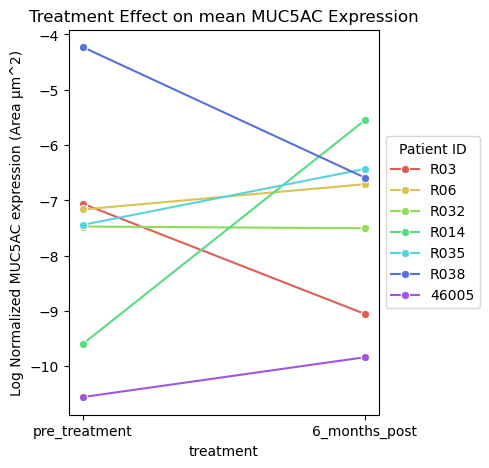

In [45]:
# Assuming df_final is your DataFrame and it contains columns 'Treatment', 'Patient_ID', and the value you want to plot
plt.figure(figsize=(4, 5))

# Create a line plot
sns.lineplot(data=df_final, 
             x='treatment', 
             y=f"Log Normalized {channel_name} expression (Area µm^2)", 
             hue='patient_ID', 
             marker='o', 
             palette= sample_id_colors)

# Add title and labels
plt.title(f'Treatment Effect on {measurement} {channel_name} Expression')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Patient ID')

plt.savefig(f'{save_fig}/lineplot_{channel_name}_{measurement}_area_log.png', bbox_inches='tight')

/var/folders/yq/6fgvx0fj0cs57zmqydzbhbfh0000gn/T/ipykernel_73359/416688304.py:5: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.lineplot(data=df_final,


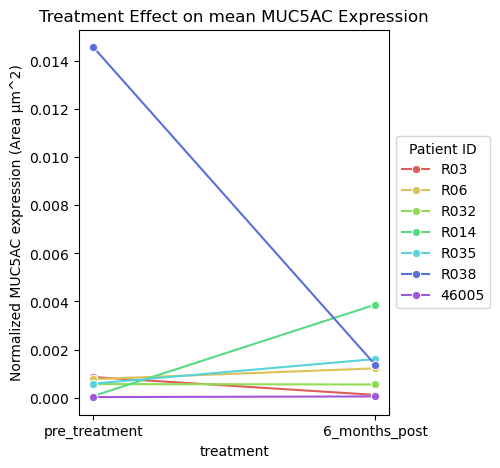

In [46]:
# Assuming df_final is your DataFrame and it contains columns 'Treatment', 'Patient_ID', and the value you want to plot
plt.figure(figsize=(4, 5))

# Create a line plot
sns.lineplot(data=df_final, 
             x='treatment', 
             y=f"Normalized {channel_name} expression (Area µm^2)", 
             hue='patient_ID', 
             marker='o', 
             palette= sample_id_colors)

# Add title and labels
plt.title(f'Treatment Effect on {measurement} {channel_name} Expression')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Patient ID')

plt.savefig(f'{save_fig}/lineplot_{channel_name}_{measurement}_area.png', bbox_inches='tight')

/var/folders/yq/6fgvx0fj0cs57zmqydzbhbfh0000gn/T/ipykernel_73359/224099811.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final,


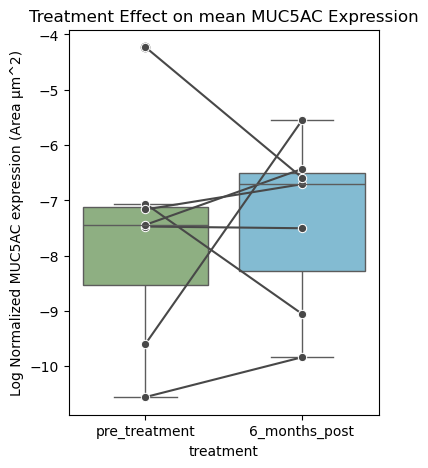

In [47]:
# Assuming df_final is your DataFrame and it contains columns 'Treatment', 'Patient_ID', and the value you want to plot
plt.figure(figsize=(4, 5))

# set colors
palette = {'pre_treatment': '#8AB67B', '6_months_post': '#76C1DF'}


# Create a boxplot
sns.boxplot(data=df_final, 
            x='treatment', 
            y=f"Log Normalized {channel_name} expression (Area µm^2)",
            palette=palette)

# Create a line plot
sns.lineplot(data=df_final, 
             x='treatment', 
             y= f"Log Normalized {channel_name} expression (Area µm^2)", 
             hue='patient_ID', 
             marker='o',
             palette=['#484848'] * df_final['patient_ID'].nunique(),
             legend=False
             )

# Add title and labels
plt.title(f'Treatment Effect on {measurement} {channel_name} Expression')

# Save plot
plt.savefig(f'{save_fig}/boxplot_{channel_name}_{measurement}_area_log.png', bbox_inches='tight')

/var/folders/yq/6fgvx0fj0cs57zmqydzbhbfh0000gn/T/ipykernel_73359/1851984448.py:8: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.lineplot(data=df_final,


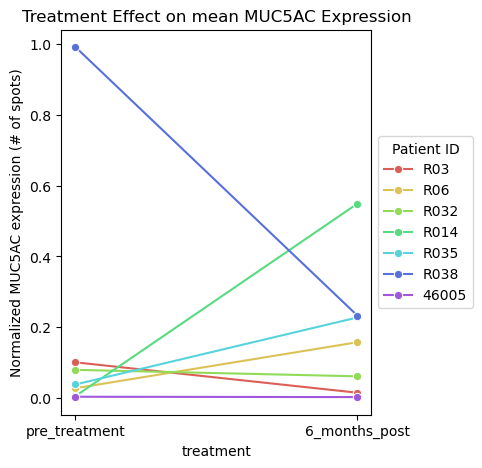

In [48]:
# Assuming df_final is your DataFrame and it contains columns 'Treatment', 'Patient_ID', and the value you want to plot
plt.figure(figsize=(4, 5))

# set colors
palette = {'pre_treatment': 'red', '6_months_post': 'blue'}

# Create a line plot
sns.lineplot(data=df_final, 
             x='treatment', 
             y= f"Normalized {channel_name} expression (# of spots)", 
             hue='patient_ID', 
             marker='o', 
             palette= sample_id_colors)

# Add title and labels
plt.title(f'Treatment Effect on {measurement} {channel_name} Expression')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Patient ID')

# Save plot
plt.savefig(f'{save_fig}/lineplot_{channel_name}_{measurement}_spots.png', bbox_inches='tight')

/var/folders/yq/6fgvx0fj0cs57zmqydzbhbfh0000gn/T/ipykernel_73359/2752079714.py:8: UserWarning: The palette list has more values (8) than needed (7), which may not be intended.
  sns.lineplot(data=df_final,


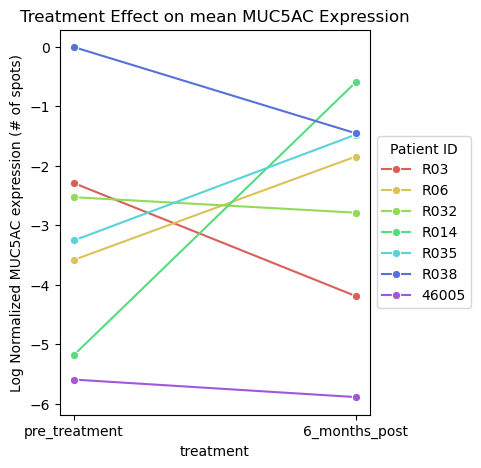

In [49]:
# Assuming df_final is your DataFrame and it contains columns 'Treatment', 'Patient_ID', and the value you want to plot
plt.figure(figsize=(4, 5))

# set colors
palette = {'pre_treatment': 'red', '6_months_post': 'blue'}

# Create a line plot
sns.lineplot(data=df_final, 
             x='treatment', 
             y= f"Log Normalized {channel_name} expression (# of spots)", 
             hue='patient_ID', 
             marker='o', 
             palette= sample_id_colors)

# Add title and labels
plt.title(f'Treatment Effect on {measurement} {channel_name} Expression')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Patient ID')

# Save plot
plt.savefig(f'{save_fig}/lineplot_{channel_name}_{measurement}_spots_log.png', bbox_inches='tight')

/var/folders/yq/6fgvx0fj0cs57zmqydzbhbfh0000gn/T/ipykernel_73359/2845356138.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_final,


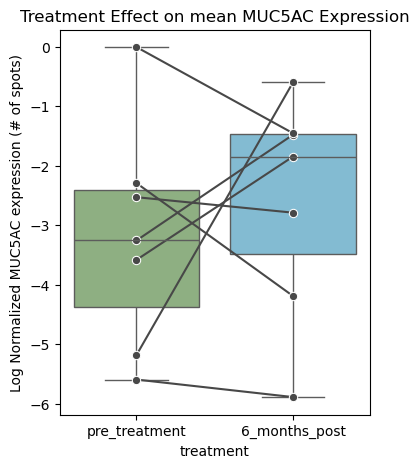

In [50]:
# Assuming df_final is your DataFrame and it contains columns 'Treatment', 'Patient_ID', and the value you want to plot
plt.figure(figsize=(4, 5))

# set colors
palette = {'pre_treatment': '#8AB67B', '6_months_post': '#76C1DF'}


# Create a boxplot
sns.boxplot(data=df_final, 
            x='treatment', 
            y=f"Log Normalized {channel_name} expression (# of spots)",
            palette=palette)

# Create a line plot
sns.lineplot(data=df_final, 
             x='treatment', 
             y= f"Log Normalized {channel_name} expression (# of spots)", 
             hue='patient_ID', 
             marker='o',
             palette=['#484848'] * df_final['patient_ID'].nunique(),
             legend=False
             )

# Add title and labels
plt.title(f'Treatment Effect on {measurement} {channel_name} Expression')

# Save plot
plt.savefig(f'{save_fig}/boxplot_{channel_name}_{measurement}_spots_log.png', bbox_inches='tight')